# Cluster and HII-regions development <a class="tocSkip">

this notebook contains small code snippets that were used to test ideas and validate concepts that are used in the main notebook. Each section should be self contained and run without the other sections (except for the first few sections, which are used throughout the notebook).

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

from pnlf.packages import *

from pnlf.constants import tab10, single_column, two_column
from pnlf.plot import quick_plot

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
logging.basicConfig(stream=sys.stdout,
                    #format='(levelname)s %(name)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger(__name__)


# first we need to specify the path to the raw data
basedir = Path('..')  # where we save stuff (and )
data_ext = Path('a:')/'Archive' # raw data

sample_table = ascii.read(basedir/'..'/'pnlf'/'data'/'interim'/'sample.txt')
sample_table.add_index('name')
sample_table['SkyCoord'] = SkyCoord(sample_table['R.A.'],sample_table['Dec.'])
sample_table['power_index'] = 2.3
sample_table['power_index'][sample_table['AO'].mask]=2.8

## Read in data

### MUSE DAP

In [ ]:
# galaxies with astrosat
hst_sample      = set(['NGC0628', 'NGC1433', 'NGC1566', 'NGC3351', 'NGC3627', 'NGC4535'])
astrosat_sample = set([x.stem for x in (data_ext/'Astrosat').iterdir() if x.stem !='images'])
muse_sample     = set(sample_table['Name'])
complete_sample = hst_sample & astrosat_sample & muse_sample

In [5]:
from pnlf.io import ReadLineMaps

name = 'NGC0628'

p = {x:sample_table.loc[name][x] for x in sample_table.columns}

# read in the data we will be working with and print some information
galaxy = ReadLineMaps(data_ext/'MUSE'/'DR2.1'/'copt',**p)
#galaxy.Ebv = sample_table.loc[name]['E(B-V)']

INFO:pnlf.io:loading NGC0628-0.92asec_MAPS.fits
INFO:pnlf.io:replacing OIII5006 map
INFO:pnlf.io:galaxy has 11 pointings
INFO:pnlf.io:file loaded with 15 extensions


### Nebulae Catalogues with masks

In [15]:
from pnlf.auxiliary import filter_table

filename = next((data_ext/'MUSE'/'DR2.1'/'copt').glob(f'{name}*.fits'))
copt_res = float(filename.stem.split('-')[1].split('asec')[0])
with fits.open(filename) as hdul:
    Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                    mask=np.isnan(hdul['HA6562_FLUX'].data),
                    meta=hdul['HA6562_FLUX'].header,
                    wcs=WCS(hdul['HA6562_FLUX'].header))

# nebulae catalogue from Francesco (mostly HII-regions)
with fits.open(basedir / 'data' / 'interim' / 'Nebulae_Catalogue_v2p1.fits') as hdul:
    nebulae = Table(hdul[1].data)
print(f'{name}: {len(nebulae)} nebulae in initial catalogue')

nebulae.rename_columns(['cen_x','cen_y'],['x','y'])

# we remove some objects that are not HII-regions
nebulae = filter_table(nebulae,gal_name=name,BPT_NII=0,BPT_SII=0,BPT_OI=0)
with np.errstate(divide='ignore'):
    nebulae['[SIII]/[SII]'] = (nebulae['SIII6312_FLUX']+nebulae['SIII9068_FLUX']) / (nebulae['SII6716_FLUX']+nebulae['SII6730_FLUX'])

#nebulae = nebulae[['region_ID','x','y','met_scal','Delta_met','logq_D91']]
nebulae.rename_columns(['region_ID','logq_D91'],['ID','ionization'])
#nebulae['SkyCoord'] = SkyCoord.from_pixel(nebulae['x'],nebulae['y'],galaxy.wcs)
nebulae['SkyCoord'] = SkyCoord(nebulae['cen_ra']*u.deg,nebulae['cen_dec']*u.deg,frame='icrs')

filename = data_ext/'Products'/'Nebulae catalogue' /'spatial_masks'/f'{name}_nebulae_mask.fits'
with fits.open(filename) as hdul:
    nebulae_mask = NDData(hdul[0].data.astype(float),mask=Halpha.mask,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    nebulae_mask.data[nebulae_mask.data==-1] = np.nan
    
print(f'{name}: {len(nebulae)} nebulae in final catalogue')

NGC0628: 31497 nebulae in initial catalogue
NGC0628: 2451 nebulae in final catalogue


### HST

* Use clusters with 'PHANGS_CLUSTER_CLASS' == 1, 2, and 3. Objects with 'PHANGS_CLUSTER_CLASS' >= 4 are actually not clusters but artifacts, individual stars, etc. Objects with no classification have not been classified yet so don't use those either. They will be classified by our machine learning in the near future though.
* If you are using the cluster properties, please use the chi2 minimized results (PHANGS_AGE_MINCHISQ, PHANGS_AGE_MINCHISQ_ERR, PHANGS_MASS_MINCHISQ, PHANGS_MASS_MINCHISQ_ERR, PHANGS_EBV_MINCHISQ, PHANGS_EBV_MINCHISQ_ERR) rather than the Bayesian estimates for now. This will change at some point in the future once the issues with the Bayesian analysis are resolved.


In [ ]:
# whitelight image
with fits.open(data_ext / 'HST' / 'white_light' / name / f'{name.lower()}_white_24rgb.fits') as hdul:
    hst_whitelight = NDData(hdul[0].data,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    hst_whitelight.data[hst_whitelight.data==0] = np.nan

In [ ]:
# cluster catalogues
filename = data_ext / 'HST' / 'cluster catalogue' / f'{name}_phangshst_base_catalog.fits'
with fits.open(filename) as hdul:
    clusters = Table(hdul[1].data)

print(f'initial catalogue has {len(clusters)} entries')    
# only CLASS 1,2 and 3 are classified as clusters
clusters = clusters[np.isin(clusters['PHANGS_CLUSTER_CLASS'],[1,2,3])]
# remove LEGUS columns
clusters = clusters[[x for x in clusters.columns if 'LEGUS' not in x]]
# remove the PHANGS label from the column names
clusters.rename_columns([x for x in clusters.columns],[x.replace('PHANGS_','') for x in clusters.columns])
# add SkyCoord to match with MUSE data
clusters['SkyCoord'] = SkyCoord(clusters['RA']*u.degree,clusters['DEC']*u.degree)
print(f'final catalogue has {len(clusters)} entries')    

In [ ]:
from astropy.nddata import Cutout2D

cutout = Cutout2D(hst_whitelight.data,clusters['SkyCoord'][10],64*u.pix,wcs=hst_whitelight.wcs)

fig = plt.figure()
ax  = fig.add_subplot(projection=cutout.wcs)

norm = simple_norm(cutout.data,clip=False)
ax.imshow(cutout.data,norm=norm,cmap=plt.cm.gray)
plt.show()

### Astrosat

https://uvit.iiap.res.in/Instrument/Filters

Ffilter = CPS x UC (ergs s-1 cm-2 A-1)
mAB = -2.5 log10 (CPS) + ZP
 
* CPS : Counts per second, the source count-rate
* UC : Unit Conversion for the filter (see the table below)
* ZP: Zero point for the filter (see the table below) 

the resolution is 0.4" per pixel. With a PSF resolution of 1.8" this leads to fwhm ~ 4.5 px. This corresponds to a std = 1.91 px

In [ ]:
# whitelight image
astro_file = data_ext / 'Astrosat' / f'{name}_FUV_F148W_flux_reproj.fits'

if not astro_file.is_file():
    astro_file = data_ext / 'Astrosat' / name / f'{name}_FUV_F154W_flux_reproj.fits'
    if not astro_file.is_file():
        print(f'no astrosat file for {name}')
    
with fits.open(astro_file) as hdul:
    astrosat = NDData(hdul[0].data,meta=hdul[0].header,wcs=WCS(hdul[0].header))

In [ ]:
quick_plot(astrosat.data,wcs=astrosat.wcs,xlim=[2100,2700],ylim=[1800,2500])

In [ ]:
from reproject import reproject_exact

FUV, footprint = reproject_exact(astrosat,galaxy.header)

In [ ]:
from pnlf.plot.plot import create_RGB

path = data_ext / 'MUSE_DR2' / 'filterImages'  

sdss_g, h = fits.getdata(path / f'{name}_IMAGE_FOV_SDSS_g_WCS_Pall_mad.fits',header=True)
sdss_r, h = fits.getdata(path / f'{name}_IMAGE_FOV_SDSS_r_WCS_Pall_mad.fits',header=True)
sdss_i, h = fits.getdata(path / f'{name}_IMAGE_FOV_SDSS_i_WCS_Pall_mad.fits',header=True)

In [ ]:
gri_composite = create_RGB(sdss_i,sdss_r,sdss_g,percentile=98)

fig = plt.figure(figsize=(8,4))
ax1  = fig.add_subplot(121,projection=WCS(h))
ax1.imshow(gri_composite)

#rgb = make_rgb_image(galaxy.HA6562,galaxy.OIII5006,FUV,vmin=0,vmax=300)

rgb = create_RGB(galaxy.HA6562,galaxy.OIII5006,FUV,percentile=98,weights=[1,1,0.8])
rgb[np.isnan(galaxy.HA6562)] = (1,1,1)

ax2  = fig.add_subplot(122,projection=galaxy.wcs)
ax2.imshow(rgb)

labels=[r'H$\alpha$','[OIII]','FUV']
handles = 3*[mpl.patches.Rectangle((0, 0), 0, 0, alpha=0.0)]
leg = ax2.legend(handles,labels, frameon=True,framealpha=0.7,handlelength=0,prop={'size': 6},loc=3)
for color,text in zip(['red','green','blue'],leg.get_texts()):
    text.set_color(color)
        
plt.savefig(basedir/'reports'/f'{name}_astrosat_rgb.pdf',dpi=800)
plt.show()

## Convolving to different PSF

https://www.astro.princeton.edu/~ganiano/Kernels/Ker_2018/Kernel_FITS_Files/Hi_Resolution/

In [20]:
from photutils import create_matching_kernel, TopHatWindow, CosineBellWindow
from astropy.modeling.models import Gaussian2D, Moffat2D
from astropy.convolution import convolve
from astropy.stats import gaussian_sigma_to_fwhm, gaussian_fwhm_to_sigma

the fwhm varies between 3 and 4.2 ($\gamma=2.8$ bis $3.9$)

In [21]:
def gaussian_to_moffat(std,alpha,gamma,size=32,window=None):
    '''create a kernel to convolve from moffat to gaussian'''

    fwhm_gauss  = std * gaussian_sigma_to_fwhm
    fwhm_moffat = gamma * (2*np.sqrt(2**(1/alpha)-1))
        
    if fwhm_gauss > fwhm_moffat:
        logger.warning('fwhm of input is larger than output')
        
    y, x = np.mgrid[0:2*size+1, 0:2*size+1]

    gm1 = Gaussian2D(1, size, size, std, std)
    g1  = gm1(x, y)
    g1 /= g1.sum()
    
    gm2 = Moffat2D(1,size,size,alpha=alpha,gamma=gamma)
    g2  = gm2(x,y)
    g2 /= g2.sum()

    return create_matching_kernel(g1, g2,window=window)
    
def moffat_to_gaussian(std,alpha,gamma,size=32,window=None):
    '''create a kernel to convolve from gaussian to moffat'''
    
    fwhm_gauss  = std * gaussian_sigma_to_fwhm
    fwhm_moffat = gamma * (2*np.sqrt(2**(1/alpha)-1))
        
    if fwhm_moffat > fwhm_gauss:
        logger.warning('fwhm of input is larger than output')
        
    y, x = np.mgrid[0:2*size+1, 0:2*size+1]

    gm1 = Moffat2D(1,size,size,alpha=alpha,gamma=gamma)
    g1  = gm1(x,y)
    g1 /= g1.sum()

    gm2 = Gaussian2D(1, size, size, std, std)
    g2  = gm2(x, y)
    g2 /= g2.sum()

    return create_matching_kernel(g1, g2,window=window)

def gaussian_to_gaussian(std_in,std_out,size=32,window=None):
    '''create a kernel to convolve from gaussian to gaussian'''
    
        
    if std_in > std_out:
        logger.warning('fwhm of input is larger than output')
        
    y, x = np.mgrid[0:2*size+1, 0:2*size+1]

    gm1 = Gaussian2D(1, size, size, std_in, std_in)
    g1  = gm1(x,y)
    g1 /= g1.sum()

    gm2 = Gaussian2D(1, size, size, std_out, std_out)
    g2  = gm2(x, y)
    g2 /= g2.sum()

    return create_matching_kernel(g1, g2,window=window)

we create a perfect 2D Moffat and convolve it to a larger Gaussian. Then we try to fit the convolved image.

Astrosat has a PSF of $\sigma=1.9px$

In [ ]:
from pnlf.photometry import growth_curve

size  = 32
std   = 2
alpha = 2.8
gamma = 3
fwhm_m = gamma * (2*np.sqrt(2**(1/alpha)-1))

y, x = np.mgrid[0:2*size+1, 0:2*size+1]
gm = Moffat2D(1,size,size,alpha,gamma)
g  = gm(x,y)
g /= g.sum()

convolved = convolve(g,moffat_to_gaussian(std,alpha,gamma,window=CosineBellWindow(0.9)),preserve_nan=True)

fwhm = growth_curve(convolved,size,size,'gaussian',rmax=30,alpha=alpha,plot=True)
print(f'fwhm_moffat={fwhm_m:.2f}, fwhm_g={gaussian_sigma_to_fwhm*std:.2f}, fwhm_measured: {fwhm[0][0]:.2f}')

In [ ]:
with fits.open(basedir/'data'/'external'/'Kernel_HiRes_Moffet_01.5_to_Gauss_02.0.fits') as hdul:
    moffat_to_gaussian = hdul[0].data
    moffat_to_gaussian_header = hdul[0].header

### re-measure H$\alpha$

https://en.wikipedia.org/wiki/Ultraviolet

In [16]:
from astrotools.regions import Regions

muse_regions = Regions(mask=nebulae_mask.data,projection=nebulae_mask.meta,bkg=-1)

INFO:astrotools.regions.core:initialized with 2869 regions


In [17]:
flux = np.array([np.sum(galaxy.HA6562[muse_regions.mask==ID]) for ID in nebulae['ID']])

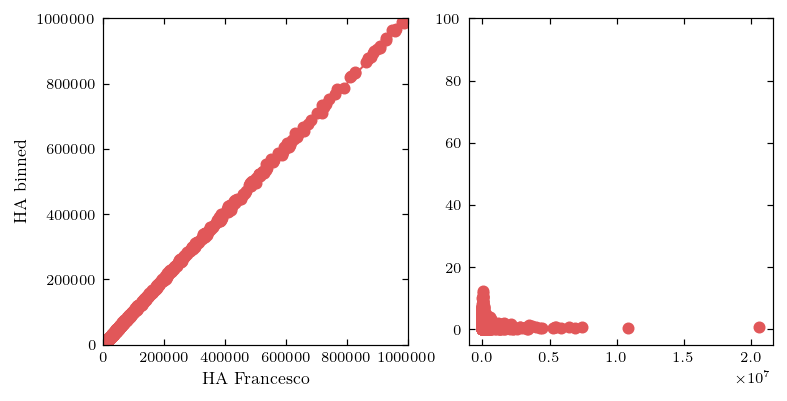

In [18]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(6,3))
lim = [0,1e6]
ax1.scatter(nebulae['HA6562_FLUX'],flux)
ax1.plot(lim,lim)
ax1.set(xlim=lim,ylim=lim,xlabel='HA Francesco',ylabel='HA binned')

ax2.scatter(nebulae['HA6562_FLUX'],100*np.abs((nebulae['HA6562_FLUX']-flux)/nebulae['HA6562_FLUX']))
ax2.set_ylim([-5,100])

#plt.savefig(basedir/'reports'/'HII_fluxes_native_DR1.pdf',dpi=600)
plt.show()

### Convolve MUSE data

In [22]:
# we convolve the convolved MUSE maps to astrosat
kernel = gaussian_to_gaussian(std_in  = 0.92*gaussian_fwhm_to_sigma, 
                            std_out = 1.9,
                            window = TopHatWindow(0.2)) 

muse_convolved = convolve(galaxy.HA6562,
                          kernel= kernel,
                          preserve_nan=True) 

In [23]:
# we use the mean fwhm
gamma  = np.nanmax(galaxy.PSF)
kernel = moffat_to_gaussian(std = 1.8,
                            alpha  = galaxy.power_index,
                            gamma  = gamma,
                            window = TopHatWindow(0.2)) 

muse_convolved = convolve(galaxy.HA6562,
                          kernel= kernel,
                          preserve_nan=True) 

In [24]:
flux_convolved = np.array([np.sum(muse_convolved[muse_regions.mask==ID]) for ID in nebulae['ID']])

76.01% under 20%


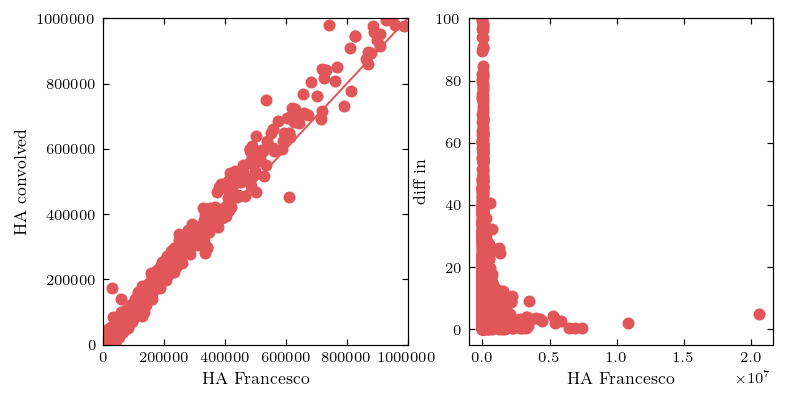

In [25]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(6,3))
lim = [0,1e6]
ax1.scatter(nebulae['HA6562_FLUX'],flux_convolved)
ax1.plot(lim,lim)
ax1.set(xlim=lim,ylim=lim,xlabel='HA Francesco',ylabel='HA convolved')

ax2.scatter(nebulae['HA6562_FLUX'],100*np.abs((nebulae['HA6562_FLUX']-flux_convolved)/nebulae['HA6562_FLUX']))
ax2.set(ylim=[-5,100],xlabel='HA Francesco',ylabel='diff in %')

print(f"{100*np.sum(np.abs((nebulae['HA6562_FLUX']-flux_convolved)/nebulae['HA6562_FLUX'])<0.2)/len(nebulae):.2f}% under 20%")

#plt.savefig(basedir/'reports'/'HII_fluxes_convolved_DR1.pdf',dpi=600)
plt.show()

#### Rebin convolved MUSE data

In [ ]:
from pnlf.auxiliary import resolution_from_wcs
from reproject import reproject_exact, reproject_interp

def block_reduce(data,header,block_size=2):
    '''
    
    CRPIXi    Reference pixel on the horizonal and vertical axis
    CRVALi    Horizonal and vertical axis WCS value at the reference pixel
    CDi_j     Rotation and scaling matrix
    '''
    
    new_header = header.copy()
    
    for i in [1,2]:
        new_header[f'CD{i}_{i}'] = header[f'CD{i}_{i}'] * block_size
        new_header[f'NAXIS{i}'] = int(header[f'NAXIS{i}'] / block_size)
        new_header[f'CRPIX{i}'] = header[f'CRPIX{i}'] / block_size
    
    new_data, footprint = reproject_exact((data, header), new_header)
    
    return new_data, new_header

In [ ]:
muse_binned, muse_binned_header = block_reduce(muse_convolved,galaxy.header,2)

In [ ]:
from pnlf.plot.plot import quick_plot

quick_plot(muse_binned,wcs=WCS(muse_binned_header))

In [ ]:
binned_regions = muse_regions.reproject(muse_binned_header)
flux_binned = np.array([np.sum(muse_binned[binned_regions.mask==ID]) for ID in nebulae['ID']])

In [ ]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(6,3))
lim = [0,1e6]
ax1.scatter(nebulae['HA6562_FLUX'],4*flux_binned)
ax1.plot(lim,lim)
ax1.set(xlim=lim,ylim=lim,xlabel='HA Francesco',ylabel='HA binned')

ax2.scatter(nebulae['HA6562_FLUX'],100*np.abs((nebulae['HA6562_FLUX']-4*flux_binned)/nebulae['HA6562_FLUX']))
ax2.set(ylim=[-5,100],xlabel='HA Francesco',ylabel='diff in %')

print(f"{100*np.sum(np.abs((nebulae['HA6562_FLUX']-4*flux_binned)/nebulae['HA6562_FLUX'])<0.2)/len(nebulae):.2f}% under 20%")

plt.savefig(basedir/'reports'/'HII_fluxes_binned_DR1.pdf',dpi=600)
plt.show()

In [ ]:
binned_regions.plot(muse_binned,filename=basedir/'reports'/'binned_regions.pdf')

In [ ]:
from astropy.nddata import Cutout2D

pos  = pn['SkyCoord'][6]
size = 20*u.arcsecond

cutout1 = Cutout2D(galaxy.OIII5006,pos,size,wcs=galaxy.wcs)
cutout2 = Cutout2D(convolved,pos,size,wcs=galaxy.wcs)
cutout3 = Cutout2D(convolved_rebin,pos,size,wcs=WCS(new_header))

fig = plt.figure(figsize=(8,4))

ax1  = fig.add_subplot(131,projection=cutout1.wcs)
norm = simple_norm(cutout1.data,clip=False,percent=99)
ax1.imshow(cutout1.data,norm=norm,cmap=plt.cm.gray)

ax2  = fig.add_subplot(132,projection=cutout2.wcs)
norm = simple_norm(cutout2.data,clip=False,percent=99)
ax2.imshow(cutout2.data,norm=norm,cmap=plt.cm.gray)

ax3  = fig.add_subplot(133,projection=cutout2.wcs)
norm = simple_norm(cutout2.data,clip=False,percent=99)
ax3.imshow(cutout2.data,norm=norm,cmap=plt.cm.gray)

plt.tight_layout()
#plt.savefig(basedir/'reports'/f'{name}_muse_convolved.pdf',dpi=800)
plt.show()

#### reproject MUSE convolved to astrosat

In [ ]:
muse_astrosat, footprint = reproject_exact((muse_binned,muse_binned_header),astrosat.meta)

In [ ]:
astrosat_regions = muse_regions.reproject(astrosat.meta)

In [ ]:
flux_astrosat = np.array([np.sum(muse_astrosat[astrosat_regions.mask==ID]) for ID in nebulae['ID']])

In [ ]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(6,3))
lim = [1e6,1e7]
ax1.scatter(nebulae['HA6562_FLUX'],4*flux_astrosat)
ax1.plot(lim,lim)
ax1.set(xlim=lim,ylim=lim,xlabel='HA Francesco',ylabel='HA binned')

ax2.scatter(nebulae['HA6562_FLUX'],100*((nebulae['HA6562_FLUX']-4*flux_astrosat)/nebulae['HA6562_FLUX']))
ax2.set(ylim=[-100,100],xlabel='HA Francesco',ylabel='diff in %')

print(f"{100*np.sum(np.abs((nebulae['HA6562_FLUX']-4*flux_astrosat)/nebulae['HA6562_FLUX'])<0.1)/len(nebulae):.2f}% under 10%")

plt.show()

or directly reproject

In [ ]:
muse_astrosat2, footprint = reproject_exact((galaxy.HA6562,galaxy.wcs),astrosat.meta)

In [ ]:
flux_astrosat2 = np.array([np.sum(muse_astrosat2[astrosat_regions.mask==ID]) for ID in nebulae['ID']])

In [ ]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(6,3))
lim = [1e6,1e7]
ax1.scatter(nebulae['HA6562_FLUX'],4*flux_astrosat2)
ax1.plot(lim,lim)
ax1.set(xlim=lim,ylim=lim,xlabel='HA Francesco',ylabel='HA binned')

ax2.scatter(nebulae['HA6562_FLUX'],100*np.abs((nebulae['HA6562_FLUX']-4*flux_astrosat2)/nebulae['HA6562_FLUX']))
ax2.set(ylim=[-5,100],xlabel='HA Francesco',ylabel='diff in %')

print(f"{100*np.sum(np.abs((nebulae['HA6562_FLUX']-4*flux_astrosat2)/nebulae['HA6562_FLUX'])<0.1)/len(nebulae):.2f}% under 10%")

plt.show()

## Measure FUV

In [ ]:
from pnlf.regions import Regions

muse_regions = Regions(mask=HII_mask.data,projection=HII_mask.meta,bkg=-1)
astrosat_regions = muse_regions.reproject(astrosat.meta)

In [ ]:
from regions import PixCoord, RectanglePixelRegion

# test if all regions fall in the astrosat image
x,y = astrosat.data.shape
image_reg = RectanglePixelRegion(PixCoord(x/2,y/2),x,y)
image_reg_sky = image_reg.to_sky(astrosat.wcs)

np.all(image_reg_sky.contains(nebulae['SkyCoord'],wcs=astrosat.wcs))

In [ ]:
from skimage.measure import find_contours
from regions import PixCoord, PolygonPixelRegion

# find the contours around the image to use as vertices for the PixelRegion
contours = find_contours(HII_mask.mask.astype(int),0.5)
# we use the region with the most vertices
coords = max(contours,key=len)
# the coordinates from find_counters are switched compared to astropy
reg_muse_pix  = PolygonPixelRegion(vertices = PixCoord(*coords.T[::-1])) 
reg_muse_sky  = reg_muse_pix.to_sky(HII_mask.wcs)

reg_muse_astro  = reg_muse_sky.to_pixel(astrosat.wcs)

# plot image
ax = quick_plot(astrosat,cmap=plt.cm.gray)
#reg_muse_hst.plot(ax=ax,color='tab:red',label='MUSE')
#x,y = nebulae['SkyCoord'].to_pixel(astrosat.wcs)
#ax.scatter(x,y,s=2,color='tab:blue',label='nebula')
ax.imshow(astrosat_regions.mask,alpha=1,cmap=plt.cm.Reds)
ax.set(xlim=(1000,3000),ylim=(1000,2700))
plt.savefig(basedir/'reports'/name/f'{name}_astrosat_regions.pdf',dpi=600)
plt.show()

In [ ]:
# we only calculate sigma for the part of the image that is actually used
from reproject import reproject_interp
muse_reproj, footprint = reproject_interp((nebulae_mask.mask,nebulae_mask.wcs),astrosat.meta)

mean,median,std=sigma_clipped_stats(astrosat.data[footprint.astype(bool)])
print(mean,median,std)

In [ ]:
from photutils import aperture_photometry

tmp = nebulae[nebulae['gal_name']==name]

flux = np.array([np.sum(astrosat.data[astrosat_regions.mask==ID]) for ID in tmp['region_ID']])
err = np.array([np.sqrt(median**2 * len(astrosat_regions.coords[astrosat_regions.labels.index(ID)][0])) for ID in tmp['region_ID']])

In [ ]:
from dust_extinction.parameter_averages import O94, CCM89

extinction_model = O94(Rv=3.1)

def extinction(EBV,EBV_err,wavelength):
    '''Calculate the extinction for a given EBV and wavelength with errors'''
    
    EBV = np.atleast_1d(EBV)
    sample_size = 100000

    ext = extinction_model.extinguish(wavelength,Ebv=EBV)
    
    EBV_rand = np.random.normal(loc=EBV,scale=EBV_err,size=(sample_size,len(EBV)))
    ext_arr  = extinction_model.extinguish(wavelength,Ebv=EBV_rand)
        
    ext_err  = np.std(ext_arr,axis=0)
    ext_mean = np.mean(ext_arr,axis=0)
    
    if True:
        fig,(ax1,ax2) =plt.subplots(nrows=1,ncols=2,figsize=(two_column,two_column/2))
        ax1.hist(EBV_rand[:,0],bins=100)
        ax1.axvline(EBV[0],color='black')
        ax1.set(xlabel='E(B-V)')
        ax2.hist(ext_arr[:,0],bins=100)
        ax2.axvline(ext[0],color='black')
        ax2.set(xlabel='extinction')
        plt.show()
 
    return ext,ext_err


# E(B-V) is estimated from nebulae. E(B-V)_star = 0.5 E(B-V)_nebulae. FUV comes directly from stars
extinction_mw  = extinction_model.extinguish(1481*u.angstrom,Ebv=0.5*p['E(B-V)'])
ext_int,ext_int_err = extinction(0.5*tmp['EBV'],tmp['EBV_ERR'],wavelength=1481*u.angstrom)

tmp['FUV'] = 1e20*flux / extinction_mw / ext_int 
tmp['FUV_err'] = tmp['FUV']*np.sqrt((err/flux)**2 + (ext_int_err/ext_int)**2)  


ext_int,ext_int_err = extinction(tmp['EBV'],tmp['EBV_ERR'],wavelength=6562*u.angstrom)

tmp['HA6562_FLUX_CORR2'] = tmp['HA6562_FLUX'] / ext_int 
tmp['HA6562_FLUX_CORR2_ERR'] = tmp['HA6562_FLUX_CORR2']*np.sqrt((tmp['HA6562_FLUX_ERR']/tmp['HA6562_FLUX'])**2 + (ext_int_err/ext_int)**2)  



### Now do it for all galaxies

!!!deprecated!!! measure_FUV.py is now used instead

In [ ]:
from pnlf.regions import Regions
from reproject import reproject_interp
from dust_extinction.parameter_averages import O94, CCM89

extinction_model = O94(Rv=3.1)

# nebulae catalogue from Francesco (mostly HII-regions)
with fits.open(data_ext / 'MUSE_DR2' / 'Nebulae catalogue' / 'Nebulae_Catalogue_DR2_native.fits') as hdul:
    nebulae = Table(hdul[1].data)
nebulae['FUV'] = np.nan
nebulae['FUV_ERR'] = np.nan
    
nebulae['gal_name'][nebulae['gal_name']=='NGC628'] = 'NGC0628'


for name in ['IC5332','NGC0628','NGC1300','NGC1365','NGC1433',
             'NGC1512','NGC1566','NGC2835','NGC3351','NGC3627','NGC4254']:
    
    print(f'start with {name}')
    p = {x:sample_table.loc[name][x] for x in sample_table.columns}

    filename = data_ext / 'MUSE_DR2' / 'Nebulae catalogue' /'spatial_masks'/f'{name}_HIIreg_mask.fits'
    with fits.open(filename) as hdul:
        HII_mask = NDData(hdul[0].data-1,meta=hdul[0].header,wcs=WCS(hdul[0].header))
        HII_mask.data[HII_mask.data==-1] = np.nan
        
    print(f'read in nebulae catalogue')
    
    # whitelight image
    astro_file = data_ext / 'Astrosat' / name / f'{name}_FUV_F148W_flux_reproj.fits'

    if not astro_file.is_file():
        astro_file = data_ext / 'Astrosat' / name / f'{name}_FUV_F154W_flux_reproj.fits'
        if not astro_file.is_file():
            print(f'no astrosat file for {name}')

    with fits.open(astro_file) as hdul:
        d = hdul[0].data
        astrosat = NDData(hdul[0].data,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    print(f'read in astrosat data')
    
    muse_regions = Regions(mask=HII_mask.data,projection=HII_mask.meta,bkg=-1)
    astrosat_regions = muse_regions.reproject(astrosat.meta)
    print('regions reprojected')
    
    muse_reproj, footprint = reproject_interp((HII_mask.mask,HII_mask.wcs),astrosat.meta)
    mean,median,std=sigma_clipped_stats(astrosat.data[footprint.astype(bool)])
    print('measuring sigma_clipped_stats')
    
    tmp = nebulae[nebulae['gal_name']==name]

    flux = np.array([np.sum(astrosat.data[astrosat_regions.mask==ID]) for ID in tmp['region_ID']])
    err = np.array([np.sqrt(median**2 * len(astrosat_regions.coords[astrosat_regions.labels.index(ID)][0])) for ID in tmp['region_ID']])
    print('measuring flux')
    
    extinction_mw  = extinction_model.extinguish(1481*u.angstrom,Ebv=0.5*p['E(B-V)'])
    extinction_int = extinction_model.extinguish(1481*u.angstrom,Ebv=0.5*tmp['EBV'])

    nebulae['FUV'][nebulae['gal_name']==name] = 1e20*flux / extinction_mw / extinction_int 
    nebulae['FUV_ERR'][nebulae['gal_name']==name] = 1e20*err  
    print('extinction correction and write to catalogue\n')
    
# write to file
primary_hdu = fits.PrimaryHDU()
table_hdu   = fits.BinTableHDU(nebulae)
hdul = fits.HDUList([primary_hdu, table_hdu])
hdul.writeto(basedir/'data'/'interim'/'Nebulae_Catalogue_with_FUV.fits',overwrite=True)

## Measure NUV

In [ ]:
from astropy.nddata import InverseVariance

gal_name = 'NGC0628'

filename = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{gal_name.lower()}_f275w_v1_exp-drc-sci.fits'
error_file = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{gal_name.lower()}_f275w_v1_err-drc-wht.fits'

if not filename.is_file():
    print(f'no NUV data for {gal_name}')
else:
    with fits.open(filename) as hdul:
        F275 = NDData(hdul[0].data,
                        mask=hdul[0].data==0,
                        meta=hdul[0].header,
                        wcs=WCS(hdul[0].header))
        with fits.open(error_file) as hdul:
            F275.uncertainty = InverseVariance(hdul[0].data)

In [ ]:
from cluster.io import read_associations

HSTband = 'nuv'
scalepc = 64

associations, associations_mask = read_associations(folder=data_ext/'HST'/'stellar_associations',target=gal_name.lower(),scalepc=scalepc,
                                                    HSTband='nuv',version=version,data='all')


In [ ]:
# measure flux in mask and covert to physical units
std_err_map = np.sqrt(1/F275.uncertainty.array)

NUV = [np.sum(F275.data[associations_mask.data==assoc_ID]) for assoc_ID in associations['assoc_ID']]
NUV_err = [np.sqrt(np.sum(std_err_map[associations_mask.data==assoc_ID]**2)) for assoc_ID in associations['assoc_ID']]

NUV_mJy = 1e3*np.array(NUV)* F275.meta['PHOTFNU']*u.mJy
NUV_mJy_err = 1e3*np.array(NUV_err)* F275.meta['PHOTFNU']*u.mJy

NUV_flam = np.array(NUV)* F275.meta['PHOTFLAM']
NUV_flam_err = np.array(NUV_err)* F275.meta['PHOTFLAM']

In [ ]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(two_column,two_column/2))

ax1.scatter(associations['NUV_dolflux_mjy'],NUV_mJy,s=1)
ax1.plot([5e-5,1],[5e-5,1],color='black')
ax1.set(xlim=[5e-5,1e0],ylim=[5e-5,1e0],xscale='log',yscale='log',
        xlabel='NUV / mJy from catalogue',ylabel='NUV / mJy from image')
ax1.set_title(r'using \texttt{PHOTFNU}')


# we are missing a factor 100 in the untis here
ax2.scatter(associations['NUV_FLUX'],NUV_flam,s=1)
ax2.plot([5e-19,5e-13],[5e-19,5e-13],color='black')
ax2.set(xlim=[5e-19,5e-15],ylim=[5e-19,5e-15],xscale='log',yscale='log',
        xlabel=r'NUV / erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$ from catalogue',ylabel=r'NUV / erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$ from image')
ax2.set_title(r'using \texttt{PHOTFLAM}')

#fig.suptitle(f'{gal_name}, NUV (F275W) for {scalepc}pc associations')
plt.tight_layout()

plt.savefig(basedir/'reports'/f'remeasure_NUV_{gal_name}_{scalepc}pc.pdf')

plt.show()

the calibrated HST data contains two keywords to convert the counts from the image to physical units. Here we use the `spectral_density` function from astropy to see if both keywords behave the way we think they should (they should give the same result)

In [ ]:
(F275.meta['PHOTFNU']*u.Jy).to(u.erg/u.s/u.cm**2/u.Angstrom,equivalencies=u.spectral_density(2704*u.AA))

In [ ]:
F275.meta['PHOTFLAM']*u.erg/u.s/u.cm**2/u.Angstrom

In [ ]:
fig,ax=plt.subplots()

ax.hist(associations['NUV_dolflux_mjy']/associations['NUV_dolflux_mjy_err'],bins=np.logspace(-1,4,20),
        label='from catalogue',alpha=0.6)
ax.hist(NUV_flam/NUV_flam_err,bins=np.logspace(-1,4,20),label='measured from mask',alpha=0.6)

ax.legend()
ax.set(xscale='log',xlabel='NUV / mJy')
plt.show()

## Compare Nebulae with Cluster catalogue and FUV

### first we create regions to see how MUSE and HST overlapp

In [ ]:
from skimage.measure import find_contours
from regions import PixCoord, PolygonPixelRegion

# find the contours around the image to use as vertices for the PixelRegion
contours = find_contours(HII_mask.mask.astype(int),0.5)
# we use the region with the most vertices
coords = max(contours,key=len)
# the coordinates from find_counters are switched compared to astropy
reg_muse  = PolygonPixelRegion(vertices = PixCoord(*coords.T[::-1])) 
reg_sky  = reg_muse.to_sky(galaxy.wcs)
reg_hst  = reg_sky.to_pixel(hst_whitelight.wcs)

# check which objects are within another 
clusters['in_image']=reg_sky.contains(clusters['SkyCoord'],hst_whitelight.wcs)

In [ ]:
# plot image
ax = quick_plot(hst_whitelight.data,wcs=hst_whitelight.wcs,cmap=plt.cm.gray)
# plot 
ax.scatter(clusters['X'][clusters['in_image']],clusters['Y'][clusters['in_image']],s=5,color='green')
reg_hst.plot(ax=ax,color='red')
plt.show()

### now we can match the catalogues

In [ ]:
from astropy.coordinates import match_coordinates_sky, search_around_sky

# it makes a different if we match the clusters to the nebulae or the other way around
matchcoord   = nebulae.copy()
catalogcoord = clusters.copy()

idx, sep, _ = match_coordinates_sky(matchcoord['SkyCoord'],catalogcoord['SkyCoord'])


In [ ]:
x_name, y_name = 'AGE_MINCHISQ', 'ionization'

matchcoord[y_name] = catalogcoord[idx][y_name]
criteria  = sep.__lt__(Angle('1"')) & ~np.isnan(matchcoord[x_name]) & ~np.isnan(matchcoord[y_name])
catalogue = matchcoord[criteria]
print(f'{len(criteria)} objects in catalogue ({np.sum(~criteria)} objects rejected)')

In [ ]:
from scipy.stats import binned_statistic, pearsonr

mean, bin_edges, binnumber = binned_statistic(catalogue[x_name],
                                              catalogue[y_name],
                                              statistic='mean',
                                              bins=20,
                                              range=[0,100])

fig,ax = plt.subplots(figsize=(6,4))

ax.errorbar((bin_edges[1:]+bin_edges[:-1])/2,mean,yerr=std,fmt='o')
ax.set(xlabel=f'{x_name.replace("_","")}',ylabel=f'{y_name}')
ax.set_title('binned statistics')
plt.show()

In [ ]:
from astropy.coordinates import match_coordinates_sky, search_around_sky
#idxc, idxn, d2d, d3d = search_around_sky(nebulae['SkyCoord'],clusters['SkyCoord'],max_sep_ang)

In [ ]:
cat = clusters[(clusters['age']>0) & (clusters['mass']>5e3)]

idx, sep2d, _ = match_coordinates_sky(nebulae['SkyCoord'],cat['SkyCoord'])

In [ ]:
catalogue = clusters[(clusters['age']>0) & (clusters['age']<10) & (clusters['mass']>0)]

# define the maximum seperation
max_sep_dis = 30 * u.pc
max_sep_ang = 206265 * (max_sep_dis / Distance(distmod=galaxy.mu)).decompose() * u.arcsec

# the new columns we want to calculate
nearby_cluster = []       # list of clusters within max_sep_ang
N_nearby_cluster = []     # number of nearby clusters
sep = []                  # distance to the nearest cluster
age = []                  # age of nearest cluster (not NaN)
mass = []                 # mass of nearest cluster (not NaN)
mass_dis = []             # distance weighted mass
for row in nebulae:
    
    separation = row['SkyCoord'].separation(catalogue['SkyCoord'])
    # mask for all clusters within max_sep_dis
    mask = separation.__lt__(max_sep_ang)

    cluster_sub = catalogue[mask]
    
    N_nearby_cluster.append(np.sum(mask))
    nearby_cluster.append('')
    
    if len(cluster_sub) > 0:
        sep.append(np.min(separation[mask]))
        age.append(np.mean(cluster_sub['age']))
        mass.append(np.sum(cluster_sub['mass']))
        mass_dis.append(np.sum(cluster_sub['mass']/separation[mask]**2).value)
    else:
        sep.append(np.inf)
        age.append(np.inf)
        mass.append(0)
        mass_dis.append(0)
        
#catalogue['nearby_clusters'] = nearby_cluster
nebulae['N_nearby_cluster'] = N_nearby_cluster
nebulae['sep'] = sep
nebulae['age'] = age
nebulae['mass'] = mass
nebulae['mass_dis'] = mass_dis


In [ ]:
nebulae[nebulae['N_nearby_cluster']>2]

In [ ]:
def plot_corner(table,rows,columns):
    '''plot rows against columns'''
    
    if set(rows)-set(table.columns):
        raise ValueError(f'missing column: {set(rows)-set(table.columns)}')
    if set(columns)-set(table.columns):
        raise ValueError(f'missing column: {set(columns)-set(table.columns)}')
        
        
    fig, axes = plt.subplots(nrows=len(rows),ncols=len(columns),
                             sharex='col',sharey='row',
                             figsize=(2*two_column,2*two_column*len(rows)/len(columns)))
    
    for i,col in enumerate(columns):
        for j,row in enumerate(rows):
            tmp = table[(table[col]>0)]
            
            ax = axes[j,i]
            ax.scatter(tmp[col],tmp[row])
                
            if j==len(rows)-1:
                ax.set_xlabel(col.replace('_',''))
                ax.set_xscale('log')
            if i%len(columns)==0:
                ax.set_ylabel(row.replace('_',''))
                #ax.set_ylim([np.nanpercentile(tmp[row],1),np.nanpercentile(tmp[row],99)])
                
    plt.subplots_adjust(hspace = .001)      
    plt.subplots_adjust(wspace = .001)      

    plt.show()
            
    
plot_corner(nebulae[nebulae['N_nearby_cluster']>0],rows=['Z_local','ionization'],columns=['N_nearby_cluster','mass','age','mass_dis'])

In [ ]:
x,y=clusters['SkyCoord'].to_pixel(galaxy.wcs)
clusters['x']=x
clusters['y']=y

In [ ]:
from pnlf.detection import match_catalogues

idx, sep = match_catalogues(clusters[['x','y']],nebulae[['x','y']])

tolerance = 5
within_tolerance = len(sep[sep<tolerance])

print(f'{within_tolerance} of {len(sep)} clusters have an HII-region within {tolerance} pixel ({within_tolerance / len(sep)*100:.1f} %)')
print(f'mean seperation is {sep[sep<tolerance].mean():.2f} pixel')

clusters['sep'] = sep
clusters['Z'] = nebulae[idx]['Z']
clusters['ionization'] = nebulae[idx]['Z']
clusters['Z_without_radial'] = nebulae[idx]['Z_local']

In [ ]:
from pnlf.plot.plot import create_RGB

#HII = nebulae[nebulae['HII_region_class']==1]

fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(projection=galaxy.wcs)

norm = simple_norm(galaxy.OIII5006_DAP,clip=False,percent=99)
#img = create_RGB(galaxy.HA6562,galaxy.OIII5006_DAP,galaxy.SII6716,weights=[0.6,1,0.6],percentile=[95,99.,95])
#ax.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Blues)
#ax.imshow(img)

ax.scatter(clusters['x'],clusters['y'],marker='o',s=3,lw=0.3,color='black',alpha=0.9,label='cluster')
im = ax.scatter(nebulae['x'],nebulae['y'],marker='o',s=5,lw=0.3,
           c=nebulae['Delta_met'], cmap=plt.cm.coolwarm,alpha=0.9,label='nebulae')
plt.colorbar(im)
plt.legend()
print(f'{len(nebulae)} HII regions\n{len(clusters)} Clusters')

filename = basedir / 'reports' / 'cluster' / 'clusters+HII.pdf'
#plt.savefig(filename,bbox_inches='tight',dpi=600)
plt.show()

### combine regions with HST

In [ ]:
from astropy.nddata import Cutout2D
from reproject import reproject_interp

target = catalogue['SkyCoord'][0]

cutout = Cutout2D(hst_whitelight.data,target,100*u.pix,wcs=hst_whitelight.wcs)

fig = plt.figure()
ax  = fig.add_subplot(projection=cutout.wcs)

# the HST whitelight image
norm = simple_norm(cutout.data,clip=False)
ax.imshow(cutout.data,norm=norm,cmap=plt.cm.gray_r)

# the mask from the nebulae catalogue
hst_mask, _ = reproject_interp(HII_mask,output_projection=cutout.wcs,shape_out=cutout.shape,order='nearest-neighbor')
for i in np.unique(hst_mask[~np.isnan(hst_mask)]):
    if i in nebulae['ID']:
        hst_mask[hst_mask==i] = nebulae['ionization'][nebulae['ID']==i]
    else:
        hst_mask[hst_mask==i] = 0
ax.imshow(hst_mask,alpha=0.5,cmap=plt.cm.Reds)

plt.show()

## Starburst99

In [ ]:
try:
    from starburst99.main import Cluster  
    from starburst99.io import read_starburst99
except ImportError:
    print('Package `starburst99` not installed')
    
star_path = Path('../../Starburst99/data')
noutput = 'cluster'

In [ ]:
def create_cluster(folder,**kwargs):

    parameters = {
    "name" : 'standard',
    "isf" : -1,
    "mass" : 1.,
    "sfr" : 1,
    "ninterv" : 2,
    "xponent" : '1.3,2.3',
    "xmaslim" : '0.1,0.5,120',
    "sncut" : 8.,
    "bhcut" : 120.,
    "model" : 64,
    "wind_model" : 0,
    "tinitial" : 0.01,
    "time_scale" : 0,
    "time_step" : 0.1,
    "n_steps" : 1000,
    "tmax" : 50,
    "jmg" : 3,
    "atmos" : 5,
    "metallicity" : 3,
    "uvline" : 1}

    # assign the new parameters
    for k,v in kwargs.items():
        if k in parameters:
            parameters[k] = v
    
    # open tempalte
    with open(basedir/'data'/'input.template') as f:
        template = f.read()
    
    template = template.format(**parameters)

    #write to templae
    with open(folder/'input.out','w') as f:
        f.write(template)
        
        


In [ ]:
from starburst99.main import Cluster
        
cluster = Cluster()

In [ ]:
from starburst99.io import read

In [ ]:
def create_cluster(filename,**kwargs):


    parameters = {
    "name" : 'standard',
    "isf" : -1,
    "mass" : 1.,
    "sfr" : 1,
    "ninterv" : 2,
    "xponent" : '1.3,2.3',
    "xmaslim" : '0.1,0.5,120',
    "sncut" : 8.,
    "bhcut" : 120.,
    "model" : 64,
    "wind_model" : 0,
    "tinitial" : 0.01,
    "time_scale" : 0,
    "time_step" : 0.1,
    "n_steps" : 1000,
    "tmax" : 50,
    "jmg" : 3,
    "atmos" : 5,
    "metallicity" : 3,
    "uvline" : 1}

    # assign the new parameters
    for k,v in kwargs.items():
        if k in parameters:
            parameters[k] = v
    
    # open tempalte
    with open(star_path/'input.template') as f:
        template = f.read()
    
    template = template.format(**parameters)

    #write to templae
    with open(star_path/'input.out','w') as f:
        f.write(template)
        
create_cluster(None,model=34,sncut=12)

In [ ]:
cluster1e4 = Cluster(star_path / 'GENEVA_v40_0.014_1e4Msun' / noutput)


In [ ]:
cluster1e4 = Cluster(star_path / 'GENEVA_v40_0.014_1e4Msun' / noutput)
cluster1e6 = Cluster(star_path / 'GENEVA_v40_0.014_1e6Msun' / noutput)
cluster_new = cluster1e4.scale(1e6)

### Compare results of the scaling

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

tablename = 'yields'

tbl1 = getattr(cluster1e4,tablename)
tbl2 = getattr(cluster1e6,tablename)
tbl3 = getattr(cluster_new,tablename)

for col in tbl1.columns[1:]:
    color = next(ax._get_lines.prop_cycler)['color']
    
    ax.plot(tbl1['Time'],tbl1[col],color=color,ls='--',label=col.replace('_',''))
    ax.plot(tbl2['Time'],tbl2[col],color=color,ls=':',lw=2)
    ax.plot(tbl3['Time'],tbl3[col],color=color,lw=0.5)

print('-- : 1e4, .. : 1e6, __ : scaled')
#ax.set_yscale('log')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

tablename = 'yields'
column = 'O'
tbl1 = getattr(cluster1e4,tablename)
tbl2 = getattr(cluster1e6,tablename)
tbl3 = getattr(cluster_new,tablename)



color = next(ax._get_lines.prop_cycler)['color']
    
ax.plot(tbl1['Time'],tbl1[column],color=color,ls='--',label='1e4')
ax.plot(tbl2['Time'],tbl2[column],color=color,ls=':',lw=2,label='1e6')
ax.plot(tbl3['Time'],tbl3[column],color=color,lw=0.5,label='scaled')

plt.legend()
ax.set_yscale('log')
#plt.legend()
plt.show()

## With SITELLE data

In [ ]:
from dust_extinction.parameter_averages import CCM89

In [ ]:
with fits.open(basedir/'..'/'sitelle'/'data'/f'{name}_nebulae_OII.fits') as hdul:
    OII_fluxes = Table(hdul[1].data)

In [ ]:
from dust_extinction.parameter_averages import CCM89

name = 'NGC3351'
Rv = 3.1
Ebv = 0.062

with fits.open(basedir/'..'/'sitelle'/'data'/f'{name}_nebulae_OII.fits') as hdul:
    OII_fluxes = Table(hdul[1].data)
    
    
with fits.open(data_ext/'MUSE'/'DR1'/'AUXILIARY'/'Nebulae catalogue'/'Nebulae_Catalogue.fits') as hdul:
    nebulae_catalogue = Table(hdul[1].data)
    
nebulae_catalogue = nebulae_catalogue[nebulae_catalogue['gal_name']==name]

extinction_model = CCM89(Rv=Rv)
extinction = extinction_model.extinguish(3627*u.angstrom,Ebv=Ebv)

for col in ['OII3727_FLUX','OII3729_FLUX','OII3727_FLUX_ERR','OII3729_FLUX_ERR']:
    nebulae_catalogue[col] = OII_fluxes[col]*1e20 /  extinction


In [ ]:
def strong_line_method(tbl):
    
    R2 = (tbl['OII3727_FLUX']+tbl['OII3729_FLUX']) / tbl['HB4861_FLUX_CORR']
    N2 = ((1+0.327)*tbl['NII6583_FLUX_CORR']) / tbl['HB4861_FLUX_CORR']
    R3 = ((1+0.340)*tbl['OIII5006_FLUX_CORR']) / tbl['HB4861_FLUX_CORR']
       
    mask= N2>-0.6
    
    
    OH_upper = 8.589 + 0.022*np.log10(R3/R2) + 0.399*np.log10(N2) + (-0.137+0.164*np.log10(R3/R2) + 0.589*np.log10(N2))*np.log10(R2)
    OH_lower = 7.932 + 0.944*np.log10(R3/R2) + 0.695*np.log10(N2) + (0.970+0.291*np.log10(R3/R2) -0.019*np.log10(N2))*np.log10(R2)
    
    OH = OH_lower
    OH[mask] = OH_upper[mask]
    
    return OH
          
nebulae_catalogue['12+(O/H)'] = strong_line_method(nebulae_catalogue)

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(nebulae_catalogue['12+(O/H)'],nebulae_catalogue['met_scal'])
ax.plot([8,10],[8,10],color='black')
ax.set(xlim=[8.4,8.7],ylim=[8.4,8.7])
plt.show()

## IZI

In [ ]:
from izi.izi import izi

In [ ]:
flux=[3.44,2.286, 1, 0.553, 0.698, 2.83]
error=[0.17, 0.07,0.05, 0.023, 0.027, 0.15]
ID=['oii3726;oii3729','oiii4959;oiii5007', 'hbeta' , 'nii6548;nii6584', \
       'sii6717;sii6731', 'halpha']
   
out2=izi(flux, error, ID,\
    intergridfile='interpolgrid_50_50d13_kappa20',
    epsilon=0.1, quiet=False, plot=True)

In [ ]:
flux=[3.44,2.286, 1]
error=[0.17, 0.07,0.05]
id=['oii3726;oii3729','oiii4959;oiii5007', 'hbeta' ]
   
out2=izi(flux, error, id,\
    intergridfile='interpolgrid_50_50d13_kappa20',
    epsilon=0.1, quiet=False, plot=True)

In [ ]:
flux=[3.44,0.553]
error=[0.17, 0.023]
id=['oii3726;oii3729', 'nii6548;nii6584']
   
out2=izi(flux, error, id,\
    intergridfile='interpolgrid_50_50d13_kappa20',
    epsilon=0.1, quiet=False, plot=True)

In [ ]:
flux=[0.553,  2.83]
error=[0.023,  0.15]
id=[ 'nii6548;nii6584', 'halpha']
   
out2=izi(flux, error, id,\
    intergridfile='interpolgrid_50_50d13_kappa20',
    epsilon=0.1, quiet=False, plot=True)

### IZI_mcmc

In [ ]:
from izi.izi_MCMC import izi_MCMC

In [ ]:
flux=[3.44,2.286, 1, 0.553, 0.698, 2.83]
error=[0.17, 0.07,0.05, 0.023, 0.027, 0.15]
id=['oii3726;oii3729','oiii4959;oiii5007', 'hbeta' , 'nii6548;nii6584', \
       'sii6717;sii6731', 'halpha']

out2=izi_MCMC(flux, error, id,\
     intergridfile='interpolgrid_100_100d13_kappaINF', epsilon=0.1, quiet=False, 
     plot=True,plot_z_steps=False,plot_q_steps=False,
     logqprior=None)

In [ ]:
out2=izi_MCMC(flux, error, id,
    intergridfile='interpolgrid_100_100d13_kappaINF', epsilon=0.1, quiet=False, 
    plot=False,logqprior=[7.1,0.5],plot_q_steps=True)

In [ ]:
import corner
samples = out2.samples
ndim=3

# This is the empirical mean of the sample:
value0 = np.median(samples, axis=0)
valueup = np.percentile(samples,  66, axis=0)
valuedown = np.percentile(samples, 34, axis=0)
print(value0, valueup, valuedown)

# Make the base corner plot
figure = corner.corner(samples, \
                labels=[r"$\rm 12+log(O/H)$", r"$\rm q \ [cm^{-2}]$",  \
                        r"$ \rm E(B-V)  \ [mag]$"],\
                show_titles=True,
                title_kwargs={"fontsize": 10},\
                label_kwargs={"fontsize": 14},\
                data_kwargs={"ms": 0.6})

# Extract the axes

axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]

    ax.axvline(value0[i], color="r")
    ax.axvline(valueup[i], color="r", ls='--')
    ax.axvline(valuedown[i], color="r", ls='--')
#    ax.axhline(value1[i], color="b")
    
plt.show()

### use on Nebulae catalogue

the following two lines are not supported by IZI
 'OI6363_FLUX', 'OII7330_FLUX''

In [ ]:
from izi.izi import izi
from izi.izi_MCMC import izi_MCMC

In [ ]:
names = {
 'HB4861':'hbeta',
 'OIII5006':'oiii5007',
 'HA6562':'halpha',
 'NII6583':'nii6584',
 'SII6716':'sii6717',
 'SII6730':'sii6731',
 'SIII9068':'siii9068',
 'OI6300':'oi6300',
 'NII5754':'nii5755',
 'HEI5875':'hei5875',
 'SIII6312':'siii6312',
 'OII7319':'oii7318',
}

In [ ]:
all_lines = ['HB4861','OIII5006','NII5754','OI6300','SIII6312',
             'HA6562','NII6583','SII6716','SII6730','OII7319','SIII9068']
small = ['HB4861','OIII5006','HA6562','NII6583','SII6716','SII6730','SIII9068']

lines = small

In [ ]:
ID    = [names[line] for line in lines]

for num in range(5):
    flux  = np.array(list(nebulae[[line+'_FLUX_CORR' for line in lines]][num]))
    error = np.array(list(nebulae[[line+'_FLUX_CORR_ERR' for line in lines]][num]))

    out=izi(flux,error, ID,plot=False,quiet=True)
    print(f'NC: Z={nebulae["Z"][num]:.2f} vs IZI: Z={out.sol["Z_joint"]:.2f}')

In [ ]:
ID = [names[line] for line in lines]

for num in range(5):

    flux  = np.array(list(nebulae[[line+'_FLUX' for line in lines]][num]))
    error = np.array(list(nebulae[[line+'_FLUX_ERR' for line in lines]][num]))
    
    out_mcmc = izi_MCMC(flux,error,ID,plot=False,quiet=True)
    print(f'NC: Z={nebulae["Z"][num]:.2f} vs IZI: Z={out_mcmc.sol["Z"]:.2f}')

## MUSE HII-regions over HST

In [ ]:
muse_regions = Regions(mask=HII_mask.data,projection=HII_mask.meta,bkg=-1)

In [ ]:
hst_regions = muse_regions.reproject(hst_whitelight.meta)

In [ ]:
from astropy.nddata import Cutout2D
from skimage.measure import regionprops, find_contours
from reproject import reproject_exact

from pnlf.auxiliary import nanunique

In [ ]:
bkg = -1

coords = []
labels  = []
for prop in regionprops(mask.data.astype(int)-bkg):
    x,y = prop.coords.T
    coords.append((x,y))
    labels.append(prop.label+bkg)

contours = find_contours(mask.data,0.5)

In [ ]:
wcs = hst.wcs

world = [mask.wcs.all_pix2world(np.array(c[::-1]).T,0) for c in coords]
output_pix = []
for c in world:
    x,y = np.unique(wcs.all_world2pix(c,0).astype(int),axis=0).T[::-1]
    output_pix.append((x,y))
    
hst_mask = np.zeros(hst.shape)*np.nan
for r,l in zip(output_pix,labels):
    hst_mask[r] = l

### Plot one HII-region

In [ ]:
pos  = tbl['SkyCoord'][20]
size = 20*u.arcsec

HII  = Cutout2D(galaxy.HA6562,pos,size=size,wcs=galaxy.wcs)
mask = Cutout2D(HII_mask.data,pos,size=size,wcs=HII_mask.wcs)
mask.data[mask.data==-1]=np.nan
hst  = Cutout2D(hst_whitelight.data,pos,size=size,wcs=hst_whitelight.wcs)

In [ ]:
from reproject import reproject_exactp

new_mask, footprint = reproject_exact((mask.data,mask.wcs),output_projection=hst.wcs,shape_out=hst.shape)
hst_mask = np.zeros_like(new_mask)*np.nan
for l in nanunique(mask.data):
    hst_mask[new_mask==l] = 1

In [ ]:
fig = plt.figure(figsize=(9,3))

norm = simple_norm(HII.data,'linear',clip=False,percent=99)
ax1  = fig.add_subplot(131,projection=HII.wcs)
ax1.imshow(HII.data,norm=norm,cmap=plt.cm.hot)

ax2  = fig.add_subplot(132,projection=mask.wcs)
ax2.imshow(mask.data)

norm = simple_norm(hst.data,'linear',clip=False,percent=99)
ax3  = fig.add_subplot(133,projection=hst.wcs)
ax3.imshow(hst.data,norm=norm,cmap=plt.cm.gray_r)
ax3.imshow(hst_mask,alpha=0.3,cmap=plt.cm.Reds_r)

plt.tight_layout()
plt.show()

## Combine catalogues

In [ ]:
# nebulae catalogue from Francesco (mostly HII-regions)
filename = basedir / 'data' / 'interim' / f'Nebulae_Catalogue_with_FUV_DR2.fits'
with fits.open(filename) as hdul:
    nebulae_catalogue = Table(hdul[1].data)

# we remove some objects that are not HII-regions
with np.errstate(divide='ignore'):
    nebulae_catalogue['[SIII]/[SII]'] = np.nan
    SII = nebulae_catalogue['SII6716_FLUX_CORR']+nebulae_catalogue['SII6730_FLUX_CORR']
    SIII = nebulae_catalogue['SIII6312_FLUX_CORR']+nebulae_catalogue['SIII9068_FLUX_CORR']
    nebulae_catalogue[SII>0]['[SIII]/[SII]'] = SIII[SII>0]/SII[SII>0]
    nebulae_catalogue['HA/FUV'] = nebulae_catalogue['HA6562_FLUX_CORR']/nebulae_catalogue['FUV_FLUX_CORR']
    
hst_sample      = set(['NGC0628', 'NGC1433', 'NGC1566', 'NGC3351', 'NGC3627', 'NGC4535'])
muse_sample     = set(sample_table['Name'])

In [ ]:
from astropy.table import join
from cluster.regions import find_sky_region
from pnlf.auxiliary import filter_table

def get_value(data,x,y):
    shape = data.shape
    
    out = []
    for j,i in zip(x,y):
        if 0<i<shape[0] and 0<j<shape[1]:
            out.append(data[int(i),int(j)])
        else:
            out.append(np.nan)
    return out

data_ext = Path('a:') 

for name in hst_sample:
    
    print(name)
    nebulae = filter_table(nebulae_catalogue,gal_name=name)
    HII_regions = filter_table(nebulae,BPT_NII=0,BPT_SII=0,BPT_OI=0)
    
    filename = data_ext / 'MUSE_DR2' / 'MUSEDAP' / f'{name}_MAPS.fits'
    with fits.open(filename) as hdul:
        Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                        uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                        mask=np.isnan(hdul['HA6562_FLUX'].data),
                        meta=hdul['HA6562_FLUX'].header,
                        wcs=WCS(hdul['HA6562_FLUX'].header))
        OIII = NDData(data=hdul['OIII5006_FLUX'].data,
                        uncertainty=StdDevUncertainty(hdul['OIII5006_FLUX_ERR'].data),
                        mask=np.isnan(hdul['OIII5006_FLUX'].data),
                        meta=hdul['OIII5006_FLUX'].header,
                        wcs=WCS(hdul['OIII5006_FLUX'].header)) 

    filename = data_ext / 'MUSE_DR2' / 'Nebulae catalogue' /'spatial_masks'/f'{name}_HIIreg_mask.fits'
    with fits.open(filename) as hdul:
        nebulae_mask = NDData(hdul[0].data-1,mask=Halpha.mask,meta=hdul[0].header,wcs=WCS(hdul[0].header))
        nebulae_mask.data[nebulae_mask.data==-1] = np.nan
        
        
    # cluster catalogues
    filename = data_ext / 'HST' / 'cluster catalogue' / f'{name}_phangshst_base_catalog.fits'
    with fits.open(filename) as hdul:
        hst_all_objects = Table(hdul[1].data)

    # remove LEGUS columns
    hst_all_objects = hst_all_objects[[x for x in hst_all_objects.columns if 'LEGUS' not in x]]
    # remove the PHANGS label from the column names
    hst_all_objects.rename_columns([x for x in hst_all_objects.columns],[x.replace('PHANGS_','') for x in hst_all_objects.columns])
    # add SkyCoord to match with MUSE data
    hst_all_objects['SkyCoord'] = SkyCoord(hst_all_objects['RA']*u.degree,hst_all_objects['DEC']*u.degree)

    reg_muse_pix, reg_muse_sky = find_sky_region(nebulae_mask.mask.astype(int),wcs=nebulae_mask.wcs)

    hst_all_objects['in_frame'] = reg_muse_sky.contains(hst_all_objects['SkyCoord'],nebulae_mask.wcs)
    hst_all_objects['MUSE_X'],hst_all_objects['MUSE_Y'] = hst_all_objects['SkyCoord'].to_pixel(nebulae_mask.wcs)

    hst_all_objects['region_ID'] = np.nan
    hst_all_objects['region_ID'][hst_all_objects['in_frame']] = get_value(nebulae_mask.data,x=hst_all_objects['MUSE_X'][hst_all_objects['in_frame']],y=hst_all_objects['MUSE_Y'][hst_all_objects['in_frame']])
    # we exclude clusters in PNe and SNRs 
    hst_all_objects['region_ID'][~np.isin(hst_all_objects['region_ID'],HII_regions['region_ID'])] = np.nan

    region_ID = hst_all_objects['region_ID']
    print(f'{np.sum(~np.isnan(region_ID))} inside and {np.sum(np.isnan(region_ID))} outside of nebulae')
    unique, counts = np.unique(region_ID[~np.isnan(region_ID)],return_counts=True)
    isolated_clusters = filter_table(hst_all_objects[np.isin(hst_all_objects['region_ID'],unique[counts==1])],CLUSTER_CLASS=[1,2,3])
    print(f'{len(isolated_clusters)} isolated clusters (no other objects in nebulae)')

    isolated_nebulae = nebulae[np.isin(nebulae['region_ID'],isolated_clusters['region_ID'])]

    catalogue = join(isolated_clusters,isolated_nebulae,keys='region_ID')

    del catalogue['SkyCoord']

    # write to file
    primary_hdu = fits.PrimaryHDU()
    table_hdu   = fits.BinTableHDU(catalogue)
    hdul = fits.HDUList([primary_hdu, table_hdu])
    hdul.writeto(basedir/'data'/'interim'/f'{name}_Clusters+Nebulae.fits',overwrite=True)


In [ ]:
# create a new table
if 'catalogue' in locals(): del catalogue
    
for filename in [x for x in (basedir/'data'/'interim').iterdir() if  x.stem.endswith('Clusters+Nebulae')]:
    
    # cluster catalogues
    with fits.open(filename) as hdul:
        tbl = Table(hdul[1].data) 
 
    if 'catalogue' in locals():
        catalogue = vstack([catalogue,tbl])
    else:
        catalogue = tbl


In [ ]:
catalogue

## 2D histogram with log


In [ ]:
from scipy.interpolate import interpn

# nebulae catalogue from Francesco (mostly HII-regions)
with fits.open(data_ext / 'Products' / 'Nebulae catalogue' / 'Nebulae_catalogue_v2.fits') as hdul:
    nebulae = Table(hdul[1].data)
    
nebulae['[SIII]/[SII]'] = np.nan
SII = nebulae['SII6716_FLUX_CORR']+nebulae['SII6730_FLUX_CORR']
SIII = nebulae['SIII6312_FLUX_CORR']+nebulae['SIII9068_FLUX_CORR']
nebulae['[SIII]/[SII]'][SII>0] = SIII[SII>0]/SII[SII>0]
nebulae['[SIII]/[SII]_err'] = np.sqrt( ( (nebulae['SIII6312_FLUX_CORR_ERR']**2+nebulae['SIII9068_FLUX_CORR_ERR']**2)*SII**2 + (nebulae['SII6716_FLUX_CORR_ERR']**2+nebulae['SII6730_FLUX_CORR_ERR']**2)*SIII**2) / SII**4)


x = nebulae['[SIII]/[SII]']
y = nebulae['Delta_met_scal']

x,y = x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)]

#x,y = x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)]

xlim=[6e-2,6e-1]
ylim=[-0.1,0.1]
nbins=32

fig,ax=plt.subplots(figsize=(two_column,two_column))

bins = [np.logspace(*np.log10(xlim),nbins),np.linspace(*ylim,nbins)]
hist, x_e, y_e = np.histogram2d(x,y,bins=bins,density=True)
#hist[hist==0]=np.nan
z = interpn((0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ),hist,np.vstack([x,y]).T,method="nearest",bounds_error=False)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

#im = ax.imshow(hist.T,aspect='auto',origin='lower',extent=[*xlim,*ylim],cmap=plt.cm.gray_r)
ax.pcolormesh(x_e,y_e,hist.T,cmap=plt.cm.gray_r)
ax.scatter(x,y,c=z)


ax.set(xscale='log',xlim=xlim,ylim=ylim)

plt.show()